In [3]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('lab08.ok')

Assignment: lab08
OK, version v1.13.11



# Lab 8: Loss Minimization

## Modeling, Estimation, and Gradient Descent

## This Assignment
In this notebook, we explore modeling data, estimating optimal parameters, and a numerical estimation method called gradient descent. These concepts are some of the fundamentals of data science and machine learning and will serve as the building blocks for future projects, classes, and work.

In this discussion, you will:

- Practice reasoning about a model

- Build some intuition for loss functions and how they behave 

- Work through deriving the gradient of a loss with respect to model parameters

- Work through a basic version of gradient descent.

This discussion is comprised of completing code, deriving analytic solutions, writing LaTeX and visualizing loss.

This assignment should be completed and submitted before Tuesday, July 23, 2019 at 11:59 PM.


# Getting Started

In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import seaborn as sns

# Set some parameters
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 16
np.set_printoptions(4)

In [5]:
# We will use plot_3d helper function to help us visualize gradient
from lab08_utils import plot_3d

## Load Data
Load the data.csv file into a pandas dataframe.  
Note that we are reading the data directly from the URL address.

In [6]:
# Run this cell to load our sample data
data = pd.read_csv("https://github.com/DS-100/su19/raw/gh-pages/assets/datasets/disc08_data.csv", index_col=0)
data.head()

,x,y
0,-5.000000,-7.672309
1,-4.966555,-7.779735
2,-4.933110,-7.995938
3,-4.899666,-8.197059
4,-4.866221,-8.183883


---
## A Simple Model
Let's start by examining our data and creating a simple model that can represent this data.

First, let's visualize the data in a scatter plot.

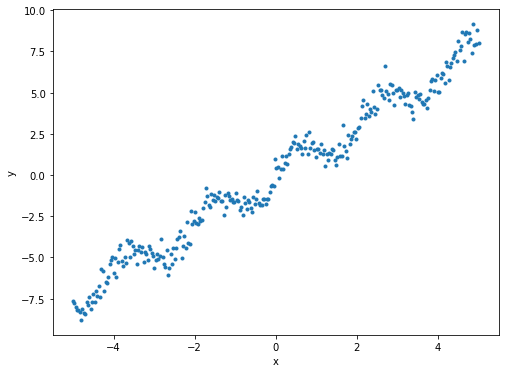

In [7]:
def scatter(x, y):
    """
    Generate a scatter plot using x and y

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    """
    plt.figure(figsize=(8, 6))
    ...
    plt.scatter(x, y, marker='.')
    plt.xlabel('x')
    plt.ylabel('y')
x = data['x']
y = data['y']
scatter(x,y)

The data looks roughly linear, with some extra sinusoidal noise. For now, let's assume that the data follows some underlying linear model. We define the underlying linear model that predicts the value $y$ using the value $x$ as: $f_{\theta^*}(x) = \theta^* \cdot x$

Since we cannot find the value of the population parameter $\theta^*$ exactly, we will assume that our dataset approximates our population and use our dataset to estimate $\theta^*$. We denote an estimate with $\theta$ and the fitted estimated chosen based on the data as $\hat{\theta}$. Our parameterized model is:

$$\Large
f_{\theta}(x) = \theta \cdot x
$$

Based on this equation, we will define the linear model function `linear_model` below to estimate $\textbf{y}$ (the $y$-values) given $\textbf{x}$ (the $x$-values) and $\theta$. This model is similar to the model you defined in the Modeling and Estimation lab.

In [8]:
def linear_model(x, theta):
    """
    Returns the estimate of y given x and theta

    Keyword arguments:
    x -- the vector of values x
    theta -- the scalar theta
    """
    return theta * x

In class, we learned that the squared loss function is smooth and continuous. Let's use squared loss to evaluate our estimate $\theta$, which we will use later to identify an optimal $\theta$, denoted $\hat{\theta}$. For several points, we compute the average loss or *empirical risk*.

In [9]:
def average_squared_loss(y, y_hat):
    """
    Returns the averge squared loss for observations y and predictions y_hat.

    Keyword arguments:
    y -- the vector of true values y
    y_hat -- the vector of predicted values y_hat
    """
    return np.mean(np.square(y - y_hat))

Finally, we will visualize the average squared loss as a function of $\theta$, where several different values of $\theta$ are given.

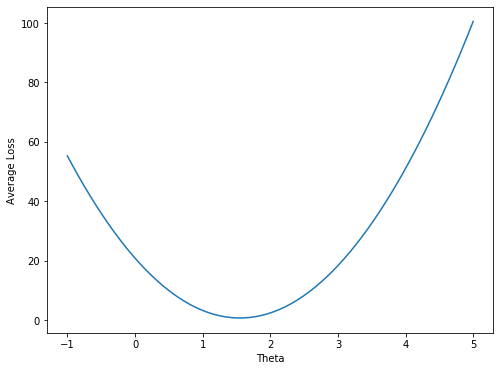

In [10]:
def visualize(x, y, thetas):
    """
    Plots the average l2 loss for given x, y as a function of theta.
    Use the functions you wrote for linear_model and l2_loss.

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    thetas -- an array containing different estimates of the scalar theta
    """ 
    avg_loss = np.array([average_squared_loss(linear_model(x, theta), y) for theta in thetas])
    plt.figure(figsize=(8,6))
    plt.plot(thetas, avg_loss)
    plt.xlabel("Theta")
    plt.ylabel("Average Loss")
    
thetas = np.linspace(-1, 5, 70)
visualize(x, y, thetas)

You should notice that $\hat{\theta}$ is approximately 1.5. 

---
## 1: Fitting our Simple Model
Now that we have defined a simple linear model and loss function, let's begin working on fitting our model to the data.

### Question 1
Let's confirm our visual findings for optimal $\hat{\theta}$.

#### Question 1a
First, find the analytical solution for the optimal $\hat{\theta}$ for average squared loss. Write up your solution in the cell below using LaTeX.

Hint: notice that we now have $\textbf{x}$ and $\textbf{y}$ instead of $x$ and $y$. This means that when writing the empirical risk function $R(\textbf{x}, \textbf{y}, \theta)$, you'll need to take the average of the squared losses for each $y_i$, $f_\theta(x_i)$ pair. For tips on getting started, see chapter 10 of the textbook (https://www.textbook.ds100.org/ch/10/modeling_loss_functions.html). Note that if you click "Open in DataHub", you can access the LaTeX source code of the book chapter, which you might find handy for typing up your work. Show your work, i.e. don't just write the answer.

<!--
BEGIN QUESTION
name: q1a
manual: True
-->
<!-- EXPORT TO PDF -->

$$L(\theta,x,y) = \frac{1}{n}\sum^{n}_{i=1}(y_i - X\theta)^2$$


$$\frac{\partial L(\theta,x,y)}{\partial \theta} = -\frac{2}{n}\sum^{n}_{i=1}(y_i - X\theta)$$

$$\frac{\partial L(\theta,x,y)}{\partial \theta} = 0$$

$$(X^TX)\hat{\theta} = X^T y$$

$$\hat{\theta} = (X^TX)^{-1}X^Ty$$

#### Question 1b
Now that we have the analytic solution for $\hat{\theta}$, implement the function `find_theta` that calculates the numerical value of $\hat{\theta}$ based on our data $\textbf{x}$, $\textbf{y}$.

<!--
BEGIN QUESTION
name: q1b
-->

In [14]:
from scipy.optimize import minimize

def find_theta(x, y):
    """
    Find optimal theta given x and y

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    """
    theta_hat = minimize(lambda theta: np.mean(average_squared_loss(y,linear_model(x,theta))), x0=0.0)['x'][0]
    return theta_hat
theta_hat = find_theta(x, y)
print(f'theta_hat = {theta_hat}')

theta_hat = 1.550264787638273


In [16]:
ok.grade("q1b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Now, let's plot our risk function again using the `visualize` function. But this time, we will add a vertical line at the optimal value of theta (plot the line $x = \hat{\theta}$).

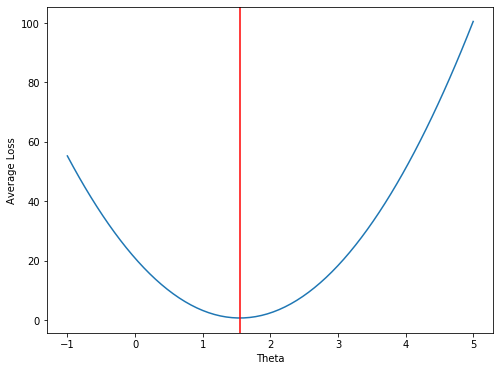

In [18]:
theta_opt = find_theta(x, y)
visualize(x, y, thetas)
plt.axvline(x=theta_opt, color='r');

We now have an optimal value for $\theta$ that minimizes the empirical risk. We can use the scatter plot of the data and add the line $f_{\hat{\theta}}(x) = \hat{\theta} \cdot \textbf{x}$ using the $\hat{\theta}$ computed above.

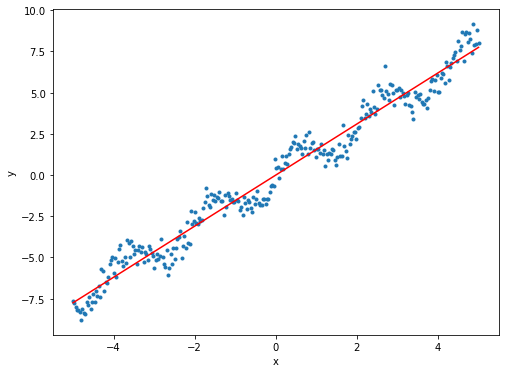

In [19]:
theta_opt = find_theta(x, y)
scatter(x, y)
line_values = linear_model(x, theta_opt)
plt.plot(x, line_values, color='r');

Great! It looks like our estimator $f_{\hat{\theta}}(x)$ is able to estimate the average y for each x quite well using a single parameter $\theta$. Now let's try to remove the linear portion of our model from the data to see if we missed anything. 

The remaining data is known as the residual, $\textbf{r}=\textbf{y}-\hat{\theta} \cdot \textbf{x}$. Below, we find the residual and plot the residuals corresponding to $x$ in a scatter plot. We also plot a horizontal line at $y=0$ to assist visualization.

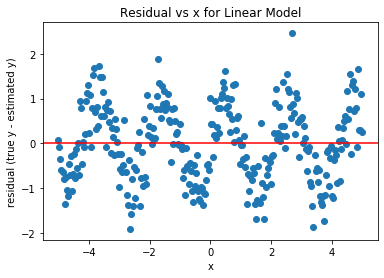

In [20]:
def visualize_residual(x, y):
    """
    Plot a scatter plot of the residuals, the remaining 
    values after removing the linear model from our data.

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    """
    ...
    theta_hat = find_theta(x, y)
    y_sin = y - linear_model(x, theta_hat)
    plt.scatter(x, y_sin)
    plt.xlabel('x')
    plt.ylabel('residual (true y - estimated y)')
    plt.title('Residual vs x for Linear Model')
    plt.axhline(y=0, color='r')

visualize_residual(x, y)

## 2: Increasing Model Complexity

It looks like the remaining data is sinusoidal, meaning our original data follows a linear function and a sinusoidal function. Let's define a new model to address this discovery and find optimal parameters to best fit the data:

$$\Large
f_\boldsymbol\theta(x) = \theta_1x + sin(\theta_2x)
$$

Now, our model is parameterized by both $\theta_1$ and $\theta_2$, or composed together, $\boldsymbol{\theta}$.

Note that a generalized sine function $a\sin(bx+c)$ has three parameters: amplitude scaling parameter $a$, frequency parameter $b$ and phase shifting parameter $c$. Looking at the residual plot above, it looks like the residual is zero at x = 0, and the residual swings between -1 and 1. Thus, it seems reasonable to effectively set the scaling and phase shifting parameter ($a$ and $c$ in this case) to 1 and 0 respectively. While we could try to fit $a$ and $c$, we're unlikely to get much benefit. When you're done with the discussion, you can try adding $a$ and $c$ to our model and fitting these values to see if you can get a better loss.

We define the `sin_model` function below that predicts $\textbf{y}$ (the $y$-values) using $\textbf{x}$ (the $x$-values) based on our new equation.

In [21]:
def sin_model(x, theta_1, theta_2):
    """
    Predict the estimate of y given x, theta_1, theta_2

    Keyword arguments:
    x -- the vector of values x
    theta_1 -- the scalar value theta_1
    theta_2 -- the scalar value theta_2
    """
    return theta_1 * x + np.sin(theta_2 * x)

#### Question 2a
Use the average squared loss to compute $\frac{\partial R }{\partial \theta_1}, \frac{\partial R }{\partial \theta_2}$. 

First, we will use LaTex to write $R(\textbf{x}, \textbf{y}, \theta_1, \theta_2)$, $\frac{\partial R }{\partial \theta_1}$, and $\frac{\partial R }{\partial \theta_2}$ given $\textbf{x}$, $\textbf{y}$, $\boldsymbol{\theta}$.

<!--
BEGIN QUESTION
name: q2a
manual: True
-->
<!-- EXPORT TO PDF -->

$$R(x,y,\theta_1,\theta_2) = \frac{1}{n}\sum^{n}_{i=1}(y_i-\theta_1x-sin(\theta_2x))^2$$

$$\frac{\partial R}{\partial \theta_1} = \frac{1}{n}\sum^n_{i=1}2(y_i-\theta_1 x-sin(\theta_2 x))(-x)$$

$$\frac{\partial R}{\partial \theta_2} = \frac{1}{n}\sum^n_{i=1}2(y_i-\theta_1x-sin(\theta_2x))(-cos(\theta_2x)x)$$


#### Question 2b
Now, implement the functions `dt1` and `dt2`, which should compute $\frac{\partial R }{\partial \theta_1}$ and $\frac{\partial R }{\partial \theta_2}$ respectively. Use the formulas you wrote for $\frac{\partial R }{\partial \theta_1}$ and $\frac{\partial R }{\partial \theta_2}$ in the previous exercise. In the functions below, the parameter `theta` is a vector that looks like $( \theta_1, \theta_2 )$.

Note: To keep your code a bit more concise, be aware that `np.mean` does the same thing as `np.sum` divided by the length of the numpy array.

<!--
BEGIN QUESTION
name: q2b
-->

In [38]:
def dt1(x, y, theta):
    """
    Compute the numerical value of the partial of l2 loss with respect to theta_1

    Keyword arguments:
    x -- the vector of all x values
    y -- the vector of all y values
    theta -- the vector of values theta
    """
    return np.mean(2*(y-theta[0]*x-np.sin(theta[1]*x))*(-x))
    
    
def dt2(x, y, theta):
    """
    Compute the numerical value of the partial of l2 loss with respect to theta_2

    Keyword arguments:
    x -- the vector of all x values
    y -- the vector of all y values
    theta -- the vector of values theta
    """
    return np.mean(2*(y-theta[0]*x-np.sin(theta[1]*x))*(-np.cos(theta[1]*x)*x))

    
# This function calls dt1 and dt2 and returns the gradient dt. It is already implemented for you.
def dt(x, y, theta):
    """
    Returns the gradient of l2 loss with respect to vector theta

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    theta -- the vector of values theta
    """
    return np.array([dt1(x,y,theta), dt2(x,y,theta)])

In [39]:
ok.grade("q2b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



---
## 3: Gradient Descent
Now try to solve for the optimal $\hat{\theta}$ analytically...

**Just kidding!**

You can try but we don't recommend it. When finding an analytic solution becomes difficult or impossible, we resort to numerical optimization. 

### Question 3

So let's try implementing a numerical optimization method: gradient descent!

#### Question 3a
Implement the `grad_desc` function that performs gradient descent for a finite number of iterations. This function takes in an array for $\textbf{x}$ (`x`), an array for $\textbf{y}$ (`y`), and an initial value for $\theta$ (`theta`). `alpha` will be the learning rate (or step size, whichever term you prefer). In this part, we'll use a static learning rate that is the same at every time step.

At each time step, use the gradient and `alpha` to update your current `theta`. Also at each time step, be sure to save the current `theta` in `theta_history`, along with the average squared loss (computed with the current `theta`) in `loss_history`.

Hints:
- Write out the gradient update equation (1 step). What variables will you need for each gradient update? Of these variables, which ones do you already have, and which ones will you need to recompute at each time step?
- You may need a loop here to update `theta` several times
- Recall that the gradient descent update function follows the form:
$$\large
\boldsymbol\theta^{(t+1)} \leftarrow \boldsymbol\theta^{(t)} - \alpha \left(\nabla_\boldsymbol\theta \mathbf{R}(\textbf{x}, \textbf{y}, \boldsymbol\theta^{(t)}) \right)
$$

<!--
BEGIN QUESTION
name: q3a
-->

In [43]:
# Run me
def init_t():
    """Creates an initial theta [0, 0] of shape (2,) as a starting point for gradient descent"""
    return np.zeros((2,))

def grad_desc(x, y, theta, num_iter=20, alpha=0.1):
    """
    Run gradient descent update for a finite number of iterations and static learning rate

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    theta -- the vector of values theta to use at first iteration
    num_iter -- the max number of iterations
    alpha -- the learning rate (also called the step size)
    
    Return:
    theta -- the optimal value of theta after num_iter of gradient descent
    theta_history -- the series of theta values over each iteration of gradient descent
    loss_history -- the series of loss values over each iteration of gradient descent
    """
    theta_history = []
    loss_history = []
    
    for i in range(num_iter):
        loss = average_squared_loss(y, sin_model(x, theta[0], theta[1]))
        loss_history.append(loss)
        theta = theta - alpha * dt(x, y, theta)
        theta_history.append(theta)
        
    
    return theta, theta_history, loss_history

t = init_t()
t_est, ts, loss = grad_desc(x, y, t, num_iter=20, alpha=0.1)

In [44]:
ok.grade("q3a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 5
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 3b
Now, let's try using a decaying learning rate. Implement `grad_desc_decay` below, which performs gradient descent with a learning rate that decreases slightly with each time step. You should be able to copy most of your work from the previous part, but you'll need to tweak how you update `theta` at each time step.

By decaying learning rate, we mean instead of just a number $\alpha$, the learning should be now $\frac{\alpha}{i+1}$ where $i$ is the current number of iteration. (Why do we need to add '+ 1' in the denominator?)

<!--
BEGIN QUESTION
name: q3b
-->

In [46]:
def grad_desc_decay(x, y, theta, num_iter=20, alpha=0.1):
    """
    Run gradient descent update for a finite number of iterations and decaying learning rate

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    theta -- the vector of values theta
    num_iter -- the max number of iterations
    alpha -- the learning rate
    
    Return:
    theta -- the optimal value of theta after num_iter of gradient descent
    theta_history -- the series of theta values over each iteration of gradient descent
    loss_history -- the series of loss values over each iteration of gradient descent
    """
    theta_history = []
    loss_history = []
    
    for i in range(num_iter):
        loss = average_squared_loss(y, sin_model(x, theta[0], theta[1]))
        loss_history.append(loss)
        theta = theta - alpha/(t+1) * dt(x, y, theta)
        theta_history.append(theta)
    
    return theta, theta_history, loss_history
t = init_t()
t_est_decay, ts_decay, loss_decay = grad_desc_decay(x, y, t, num_iter=20, alpha=0.1)

In [47]:
ok.grade("q3b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 5
    Failed: 0
[ooooooooook] 100.0% passed



Let's visually inspect our results of running gradient descent to optimize $\boldsymbol\theta$. Plot our $x$-values with our model's predicted $y$-values over the original scatter plot. You should notice that gradient descent successfully optimized $\boldsymbol\theta$.

In [48]:
# Run me
t = init_t()
t_est, ts, loss = grad_desc(x, y, t)

t = init_t()
t_est_decay, ts_decay, loss_decay = grad_desc_decay(x, y, t)

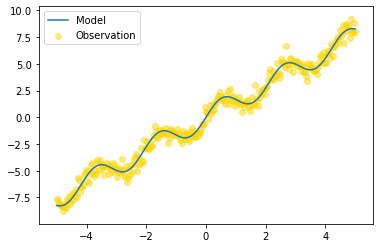

In [49]:
y_pred = sin_model(x, t_est[0], t_est[1])

plt.plot(x, y_pred, label='Model')
plt.scatter(x, y, alpha=0.5, label='Observation', color='gold')
plt.legend();

Run the following cell to see a plot of the loss values over each iteration of gradient descent for both static learning rate and decaying learning rate. 

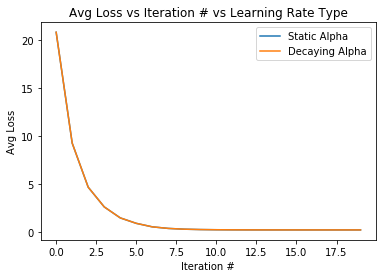

In [50]:
plt.plot(np.arange(len(loss)), loss, label='Static Alpha')
plt.plot(np.arange(len(loss)), loss_decay, label='Decaying Alpha')
plt.xlabel('Iteration #')
plt.ylabel('Avg Loss')
plt.title('Avg Loss vs Iteration # vs Learning Rate Type')
plt.legend();

You should notice that noth methods minimize loss quickly, although the implementation with a decaying step size appears to converge more quickly.

---
## Visualizing Loss
Let's visualize our loss functions and gain some insight as to how gradient descent and stochastic gradient descent are optimizing our model parameters.

In the previous plot is about the loss decrease over time, but what exactly is path the theta value? Run the following three cells. 

In [52]:
# Run me
ts = np.array(ts).squeeze()
ts_decay = np.array(ts_decay).squeeze()
loss = np.array(loss)
loss_decay = np.array(loss_decay)

In [53]:
# Run me to see a 3D plot (gradient descent with static alpha)
plot_3d(ts[:, 0], ts[:, 1], loss, average_squared_loss, sin_model, x, y)

In [54]:
# Run me to see another 3D plot (gradient descent with decaying alpha)
plot_3d(ts_decay[:, 0], ts_decay[:, 1], loss_decay, average_squared_loss, sin_model, x, y)

Another common way of visualizing 3D dynamics is with a _contour_ plot. Run the following cells.

In [55]:
## Run me
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [56]:
def contour_plot(title, theta_history, loss_function, model, x, y):
    """
    The function takes the following as argument:
        theta_history: a (N, 2) array of theta history
        loss: a list or array of loss value
        loss_function: for example, l2_loss
        model: for example, sin_model
        x: the original x input
        y: the original y output
    """
    theta_1_series = theta_history[:,0] # a list or array of theta_1 value
    theta_2_series = theta_history[:,1] # a list or array of theta_2 value

    ## In the following block of code, we generate the z value
    ## across a 2D grid
    t1_s = np.linspace(np.min(theta_1_series) - 0.1, np.max(theta_1_series) + 0.1)
    t2_s = np.linspace(np.min(theta_2_series) - 0.1, np.max(theta_2_series) + 0.1)

    x_s, y_s = np.meshgrid(t1_s, t2_s)
    data = np.stack([x_s.flatten(), y_s.flatten()]).T
    ls = []
    for t1, t2 in data:
        l = loss_function(model(x, t1, t2), y)
        ls.append(l)
    z = np.array(ls).reshape(50, 50)
    
    # Create trace of theta point
    # Create the contour 
    theta_points = go.Scatter(name="Theta Values", 
                              x=theta_1_series, 
                              y=theta_2_series,
                              mode="lines+markers")
    lr_loss_contours = go.Contour(x=t1_s, 
                                  y=t2_s, 
                                  z=z, 
                                  colorscale='Viridis', reversescale=True)

    plotly.offline.iplot(go.Figure(data=[lr_loss_contours, theta_points], layout={'title': title}))

In [57]:
# Run this
contour_plot('Gradient Descent with Static Learning Rate', ts, average_squared_loss, sin_model, x, y)

In [58]:
## Run me
contour_plot('Gradient Descent with Decay Learning Rate', ts_decay, average_squared_loss, sin_model, x, y)

# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

In [59]:
# Save your notebook first, then run this cell to submit.
import jassign.to_pdf
jassign.to_pdf.generate_pdf('lab08.ipynb', 'lab08.pdf')
ok.submit()

Generating PDF...
Saved lab08.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'lab08.ipynb'.
Submit... 100% complete
Submission successful for user: dizhen@berkeley.edu
URL: https://okpy.org/cal/data100/su19/lab08/submissions/lxl0vj

